# Introduction

In [101]:
import os
import sys
import csv
import datetime
import umap
import pandas as pd
import xgboost as xgb
import keras
import sklearn
import tensorflow
import numpy as np
import joblib
import matplotlib.pyplot as plt

from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from tsfresh import extract_features
from keras.models import Model, load_model
from keras.layers import Input, Activation, Dense, concatenate, LSTM, GRU, Dropout
from sklearn import metrics, feature_selection
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils import class_weight
from random import uniform, randint

# Data Importation

In [175]:
def import_data():
    dfx = pd.read_csv('../data/x_train.csv').set_index('ID')
    dfy = pd.read_csv('../data/y_train.csv').set_index('ID')
    dfx_test = pd.read_csv('../data/x_test.csv').set_index('ID')
    return dfx, dfy, dfx_test

In [174]:
dfx, dfy, dfx_test = import_data()
dfy.head()
dfx.tail()

,neuron_id,timestamp_0,timestamp_1,timestamp_2,timestamp_3,timestamp_4,timestamp_5,timestamp_6,timestamp_7,timestamp_8,...,timestamp_40,timestamp_41,timestamp_42,timestamp_43,timestamp_44,timestamp_45,timestamp_46,timestamp_47,timestamp_48,timestamp_49
ID,,,,,,,,,,,,,,,,,,,,,
16630,5691,0.077914,0.708334,1.009554,1.125147,1.271336,1.299890,1.666290,1.718390,2.381562,...,29.316422,30.307006,31.185741,31.227892,32.320902,32.701000,32.955075,33.016627,34.837705,34.874491
16631,2341,0.485287,0.870193,0.959064,1.733133,1.755243,1.803468,1.841432,1.986925,2.006145,...,17.151013,17.367892,17.727558,18.178916,18.521734,19.492522,19.515122,20.715555,21.217199,21.640693
16632,8046,0.213619,0.290771,1.575419,1.650658,1.700773,1.856047,1.927563,1.950001,2.367852,...,14.064862,14.092407,14.343008,14.428562,14.671081,14.791297,14.847738,14.916361,15.055357,15.192531
16633,6855,2.669642,7.500198,8.710341,8.724346,8.760471,8.770804,8.786001,8.847625,8.885186,...,15.555430,15.698512,15.782122,16.067267,16.499324,16.906955,17.444176,18.704728,22.082864,27.185064
16634,6921,0.075924,0.376280,0.445379,0.762095,0.929728,1.029945,1.622643,1.710542,2.046901,...,23.397511,23.437452,24.217391,24.519848,24.675594,24.764713,24.894686,25.041824,25.071265,28.288743


In [104]:
if dfy.shape[0] == dfx.shape[0]:
    print("Same number of samples, all good.")
else:
    print("Different number of samples, problem!")

Same number of samples, all good.


# Data Exploration

* **Sanity check:** diff etat1/etat2, neuron_id usefulness

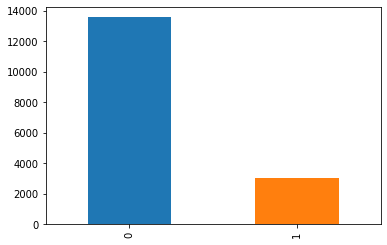

In [105]:
# Différence entre le nombre d'etats 1 et d'etats 0.
dfy.TARGET.value_counts().plot(kind='bar')
plt.show()

In [106]:
# Should we keep the neuron_id col ?
xtest_uniques = dfx_test.neuron_id.unique()
x_uniques = dfx.neuron_id.unique()
diff = [x for x in x_uniques if x in xtest_uniques]
print("There are {} neuron_ids in common between the train and test sets.".format(len(diff)))

AttributeError: 'DataFrame' object has no attribute 'neuron_id'

* **Balance dataset:** Choose between undersampling and oversampling, to get equal nb of samples per class

In [107]:
# DEPRECATED: Undersample and keep remaining indices for val split

"""
def balance_data(X, y, method="undersampling", split=1, **params):
    \""" Return balanced training dataset obtained by undersampling class 2. \"""
    y_class1_ix = np.where(y == 1)[0]
    y_class2_ix = np.where(y == 0)[0]

    # Under-sample class2 to get balanced classes
    if method == "undersampling":
        y_class2_ix = np.random.choice(y_class2_ix, int(len(y_class1_ix) * split), replace=False)
    else:
        y_class2_ix = np.random.choice(y_class2_ix, int(len(y_class2_ix) * split), replace=False)

    # Split train & val
    y_class1_ix = np.random.choice(y_class1_ix, int(len(y_class1_ix) * split), replace=False)

    # Concatenate the undersampled_class2_array and the class1_array
    balanced_ix = np.concatenate((y_class1_ix, y_class2_ix), axis=0)
#    np.random.shuffle(balanced_ix)

    # Create X_train dataset (Keras will do the val split)
    X_train = X[balanced_ix]
    y_train = y[balanced_ix]

    if method == "oversampling":
        X_train = np.reshape(X_train, X_train.shape[:2])
        ros = RandomOverSampler(random_state=0)
        X_train, y_train = ros.fit_sample(X_train, y_train)
        X_train = X_train[..., np.newaxis]
    
    # Create **UNOFFICIAL** X_val containing only 0s.
    balanced_ix_val = np.in1d(range(X.shape[0]), balanced_ix)
    
    X_val = X[~balanced_ix_val]
    y_val = y[~balanced_ix_val]
    return X_train, y_train, X_val, y_val
"""

'\ndef balance_data(X, y, method="undersampling", split=1, **params):\n    """ Return balanced training dataset obtained by undersampling class 2. """\n    y_class1_ix = np.where(y == 1)[0]\n    y_class2_ix = np.where(y == 0)[0]\n\n    # Under-sample class2 to get balanced classes\n    if method == "undersampling":\n        y_class2_ix = np.random.choice(y_class2_ix, int(len(y_class1_ix) * split), replace=False)\n    else:\n        y_class2_ix = np.random.choice(y_class2_ix, int(len(y_class2_ix) * split), replace=False)\n\n    # Split train & val\n    y_class1_ix = np.random.choice(y_class1_ix, int(len(y_class1_ix) * split), replace=False)\n\n    # Concatenate the undersampled_class2_array and the class1_array\n    balanced_ix = np.concatenate((y_class1_ix, y_class2_ix), axis=0)\n#    np.random.shuffle(balanced_ix)\n\n    # Create X_train dataset (Keras will do the val split)\n    X_train = X[balanced_ix]\n    y_train = y[balanced_ix]\n\n    if method == "oversampling":\n        X_trai

In [108]:
def balance_data(X, y, method="undersampling", **params):
    """ Return balanced training dataset obtained by undersampling class 2. """
    if method == "oversampling":
        sampler = RandomOverSampler(random_state=42)
    elif method == "undersampling":
        sampler = RandomUnderSampler(random_state=42)
    else:
        raise ValueError('Unrecognized sampling method: ', method)

    X, y = sampler.fit_resample(X, y)
    
    return X, y

* **Extract features:** Use tsfresh to perform feature engineering

In [216]:
# WIP !
def extract_tsfresh(X):
    # Create a df with integer names for columns so as to facilitate sorting
    cols = [col for col in range(1, 50)]
    ts_df = pd.DataFrame(X, columns=cols)
    
    # Stack the df to conform to tsfresh format
    ts_df = pd.DataFrame(ts_df.stack()).reset_index()
    ts_df.columns = ["ID", "timestamp", "spike_time"]
    fe_arr = extract_features(ts_df, column_id="ID", column_value="spike_time", column_sort="timestamp")
    
    # Concatenate into an array, the engineered features df and the time series df
    ts_df = ts_df.pivot(index='ID', columns='timestamp', values='spike_time')
    ts_arr = ts_df.values
    fe_arr = fe_arr.dropna(axis='columns')
    fe_arr = fe_arr.values
    X = np.concatenate((ts_arr, fe_arr), axis=1)
    
    # Save extracted features
    fname = "../data/features{}.csv".format(datetime.datetime.now().strftime("%m%d%H%M%S"))
    np.savetxt(fname, X, delimiter=",")
    return X

In [200]:
# Isolate features and DELETE NEURONID
def isolate_features(X):
    ts_arr = X[:,1:51]
    fe_arr = X[:,51:]
    return [ts_arr, fe_arr]

* **Feature engineering 2.0:** Add sums from original ts, and groupby neuron_id

In [198]:
def sommes(X, step):
    dfx, dfy, dfx_test = import_data()
    if step == "train":
        df = dfx
    else:
        df = dfx_test
        
    somme_tokeep = [10, 20, 30, 40, 50]
    somme = df.values[:,np.array(somme_tokeep)]
    X = np.concatenate((X, somme), axis=1)
    return X

#sommes(X_train)

In [217]:
def group_neurons(X):
    dfx, dfy, dfx_test = import_data()
    if step == "train":
        df = dfx
    else:
        df = dfx_test
    X_df = pd.DataFrame(X)
    neurons_df = df['neuron_id']
    neurons_df = pd.concat([neurons_df, X_df], axis=1)
    neurons_df = neurons_df.groupby(["neuron_id"]).mean()
    # Join neurons_df and X_df
    
print(group_neurons("onche").tail())

NameError: name 'step' is not defined

* **Remove features with low variance:** pretty self-explanatory

In [196]:
def remove_low_var(X, step="test"):
    if step == "train":        
        X = np.concatenate((X[:,:51], sel.fit_transform(X[:,51:])), axis=1)
    else:
        X = np.concatenate((X[:,:51], sel.transform(X[:,51:])), axis=1)
    return X

* **Standardization:** Scale features

In [197]:
def standardize_data(X, step="test"):
    """Simple standardization that accepts both a single arr, AND 2 arrays in case of RNN+FeatureEngineering"""
    def standardize(X, step):
        if step == "train":
            return scaler.fit_transform(X)
        else:
            return scaler.transform(X)

    X = np.concatenate((X[:,:51], standardize(X[:,51:], step)), axis=1)
    return X

* **Get Data:** Main function used to create numpy arrays from df

In [215]:
def getData(dfx, dfy, 
            exclude_neuron_id=True, 
            balancing="undersample",
            standardize=False,
            differencing=False,
            get_tsfresh=False,
            get_ISI_SPIKE=False,
            step="train",
            RNN=True,
            remove_low_variance=True,
            split=0.1,
            import_tsfresh=True,
            get_sum=True,
            extract_nid=True,
            **extras):    

    y = np.reshape(dfy.values, (dfy.values.shape[0],))
    
    if not import_tsfresh:
        X = dfx.values

        # Convert from timeseries to interval
        if differencing:
            X[:,2:51] -= X[:,1:50]
            #X = np.delete(X, 0, 1)
 
    if import_tsfresh:
        X = np.genfromtxt(dfx, delimiter=',')
        dfx, dfy, dfx_test = import_data()
        X = np.concatenate((dfx["neuron_id"].values, X), axis=1)
    elif get_tsfresh:
        X = extract_tsfresh(X)

    if get_tsfresh and remove_low_variance:
        X = remove_low_var(X, step)

    if get_sum:
        X = sommes(X, step)
        
    if extract_nid:
        X = group_neurons(X)
                
    if standardize:
        X = standardize_data(X, step)

    if step != "test":
        X, X_val, y, y_val = train_test_split(X, y, test_size=split, random_state=42)
    else:
        X_val = np.ones(X.shape)
        y_val = np.ones(y.shape)
    
    if step != "test" and balancing:
        X, y = balance_data(X, y, method=balancing, **params)
    
    if params["get_tsfresh"]:
        X = isolate_features(X)
        if step != "test":
            X_val = isolate_features(X_val)

    if params["RNN"]:
        X[0] = X[0][..., np.newaxis]
        if step != "test":
            X_val[0] = X_val[0][..., np.newaxis]
    
    return X, y, X_val, y_val

# Model Training

## References

* Arxiv: [Neural activity classification with machine learning models trained oninterspike interval series data](https://arxiv.org/pdf/1810.03855.pdf) => PCA and KNN
* Github: [PySpike: Python library to analyze spike Train](https://github.com/mariomulansky/PySpike) => Obscure mathematical measurements between spike trains
* Profil: [Prof expert en spike train analysis](http://xtof.perso.math.cnrs.fr/)

## Prepare experiment

In [131]:
np.random.seed(43)
tensorflow.set_random_seed(2)

In [151]:
params = {
    'name': "XGB_newts_lowvar30_sommes",
    'balancing': None,
    'standardize': True,
    'differencing': True,
    'get_tsfresh': True,
    'import_tsfresh': True,
    'get_ISI_SPIKE': False,
    'RNN': False,
    'class_weight': True,
    'remove_low_variance': True,
    'dropout': 0.2,
    'batch_size': 32,
    'split': 0.08,
    'get_sum': True
}

In [192]:
def process_data(params):
    global sel, scaler
    sel = feature_selection.VarianceThreshold(threshold=.01)
    scaler = sklearn.preprocessing.StandardScaler()
    
    dfx, dfy, dfx_test = import_data()
    
    if params['import_tsfresh']:
        X = "../data/features0624214715.csv"
        X_test = "../data/features0624220241.csv"
    else:
        X = dfx
        X_test = dfx_test

    X_train, y_train, X_val, y_val = getData(X, dfy, step="train", **params)
    X_test, _, _, _ = getData(X_test, dfy, step="test", **params)
    return X_train, y_train, X_val, y_val, X_test

In [134]:
def predict(X_test, model):
    # Predict on custom X_test
    y_pred = model.predict(X_test)
    y_pred = np.reshape(y_pred, (y_pred.shape[0],))
    print (y_pred.shape)
    
    # Convert sigmoid output to 0s and 1s
    y_pred[y_pred >= 0.5] = 1
    y_pred[y_pred < 0.5] = 0
  
    # Format .csv in ENS style
    dfy_pred = pd.DataFrame(data=y_pred, columns=["TARGET"], dtype=int)
    dfy_pred.index.name = "ID"
    dfy_pred.index += 16635
    return dfy_pred

In [135]:
def evaluate(y_true, y_pred):
    print(metrics.classification_report(y_true, y_pred))
    print(metrics.cohen_kappa_score(y_true, y_pred))

## Run training

### Deep-Learning 1: blunt RNN

In [152]:
X_train, y_train, X_val, y_val, X_test = process_data(params)

* **Create and train model**

In [ ]:
if params['get_tsfresh']:
    timestep_nb = X_train[0].shape[1]
else:
    timestep_nb = X_train.shape[1]
spike_per_ts = 1
params['cell_nb'] = 256

input_tensor = Input(shape=(timestep_nb, spike_per_ts))
X = LSTM(params['cell_nb'], return_sequences=True, dropout=params['dropout'])(input_tensor)
X = LSTM(params['cell_nb'], return_sequences=False)(X)

if params['get_tsfresh']:
    additional_features = X_train[1].shape[1]
    fe_input = Input(shape=(additional_features,)) # A tensor containing the engineered features
    latent = Dense(64, activation='relu')(fe_input)
    latent = Dropout(rate=params['dropout'])(latent)
    latent = Dense(32, activation='relu')(latent)
    latent = Dropout(rate=params['dropout'])(latent)
    input_tensor = [input_tensor, fe_input]
    X = concatenate([X, latent])   
    
output_tensor = Dense(1, activation='sigmoid')(X)

model = Model(input_tensor, output_tensor)
model.summary()

In [ ]:
if params["class_weight"]:
    class_weights = class_weight.compute_class_weight('balanced', np.unique(y_train), y_train)
else:
    class_weights = None
if params["get_tsfresh"]:
    X_train=list(X_train)
model.compile(metrics=['accuracy'], loss='mean_squared_error', optimizer='adam')
history = model.fit(X_train, y_train, epochs=2, validation_split=0.05, class_weight=class_weights, batch_size=params['batch_size'])

In [417]:
history_params = [
    ('batch_size', history.params['batch_size']),
    ('epochs', history.params['epochs']),
    ('samples', history.params['samples']),
    ('val_acc', history.history['val_acc'][-1])
    ]

params.update(history_params)

* **Evaluate**

In [418]:
if params["get_tsfresh"]:
    X_val=list(X_val)
dfy_val = predict(X_val, model)
evaluate(y_val, dfy_val)

(167,)
              precision    recall  f1-score   support

           0       0.90      0.69      0.78       127
           1       0.43      0.75      0.55        40

    accuracy                           0.71       167
   macro avg       0.67      0.72      0.67       167
weighted avg       0.79      0.71      0.73       167

0.35480564535204606


In [404]:
X_val[1].shape

(272, 324)

* **Predict**

In [ ]:
if params["get_tsfresh"]:
    X_test=list(X_test)
dfy_pred = predict(X_test, model)
dfy_pred[:35]

### Domain-knowledge 1: Benchmark = differencing + tsfresh feature engineering + XGB

In [22]:
"""
scores = []
for split in np.arange(0.2, 1, 0.1):
    params['split'] = split
    X_train, y_train, X_val, y_val, X_test = process_data(params)
    print(X_train[1].shape)
    model.fit(X_train[1], y_train)
    dfy_val = predict(X_val[1], model)
    scores.append((metrics.f1_score(y_val, dfy_val), metrics.cohen_kappa_score(y_val, dfy_val)))
"""

"\nscores = []\nfor split in np.arange(0.2, 1, 0.1):\n    params['split'] = split\n    X_train, y_train, X_val, y_val, X_test = process_data(params)\n    print(X_train[1].shape)\n    model.fit(X_train[1], y_train)\n    dfy_val = predict(X_val[1], model)\n    scores.append((metrics.f1_score(y_val, dfy_val), metrics.cohen_kappa_score(y_val, dfy_val)))\n"

In [347]:
X_train, y_train, X_val, y_val, X_test = process_data(params)

(16635, 527)
(11969, 527)


* **Train XGB**

In [153]:
if params['class_weight']:
    scale_pos_weight = np.sum(y_train == 0)/ float(np.sum(y_train == 1))
else:
    scale_pos_weight = 1

In [154]:
#XGB
params_XGB = {
        'min_child_weight': 1,
        'subsample': 0.8,
        'colsample_bytree': 0.6,
        'max_depth': 10,
        'n_estimators': 200,
        'learning_rate': 0.05,
        'scale_pos_weight': scale_pos_weight
        }
model = xgb.XGBClassifier(objective="binary:logistic", random_state=42, **params_XGB)

#SVC
#model = SVC(gamma='auto')

In [165]:
params.update(model.get_params())
params_XGB = {
        'gamma': [0.5, 1],
        }
"""
#search = RandomizedSearchCV(model, param_distributions=params_CV, rchandom_state=42,
#                            n_iter=2, cv=3, verbose=1, n_jobs=4, return_train_score=True)
"""
search = RandomizedSearchCV(model, param_distributions=params_XGB, n_iter=1, scoring='roc_auc', n_jobs=4, 
                            verbose=3, random_state=1001 )

#search.fit(X_train[1], y_train)
search.fit(select_X_train, y_train)

Fitting 3 folds for each of 1 candidates, totalling 3 fits


/goinfre/miniconda/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   3 out of   3 | elapsed:   15.4s finished


RandomizedSearchCV(cv='warn', error_score='raise-deprecating',
                   estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                           colsample_bylevel=1,
                                           colsample_bytree=0.6, gamma=0,
                                           learning_rate=0.05, max_delta_step=0,
                                           max_depth=10, min_child_weight=1,
                                           missing=None, n_estimators=200,
                                           n_jobs=1, nthread=None,
                                           objective='binary:logistic',
                                           random_state=42, reg_alpha=0,
                                           reg_lambda=1,
                                           scale_pos_weight=4.438521677327648,
                                           seed=None, silent=True,
                                           subsample=0.8),
               

In [166]:
best_xgb = search.best_estimator_

* **Train RF**

In [49]:
rf = RandomForestClassifier(n_estimators=100, max_depth=2,random_state=0, class_weight='balanced')

In [50]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 800, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [ ]:
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 6, cv = 3, verbose=2, random_state=42, n_jobs = -1, scoring='roc_auc')
rf_random.fit(select_X_train, y_train)

In [52]:
best_random = rf_random.best_estimator_

* **Select Features**

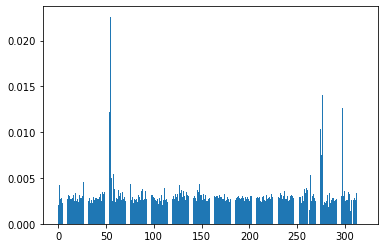

In [164]:
from matplotlib import pyplot
pyplot.bar(range(len(best_xgb.feature_importances_)), best_xgb.feature_importances_)
pyplot.show()

In [161]:
thresholds = sorted(best_xgb.feature_importances_)
thresh = thresholds[-35]
selection = sklearn.feature_selection.SelectFromModel(best_xgb, threshold=thresh, prefit=True)
select_X_train = selection.transform(X_train[1])

In [162]:
select_X_val = selection.transform(X_val[1])
select_X_test = selection.transform(X_test[1])

* **Predict**

In [167]:
#select_X_test = selection.transform(X_test[1])
dfy_pred = predict(select_X_test, best_xgb)

(11969,)


* **Evaluate**

In [169]:
#select_X_val = selection.transform(X_val[1])
dfy_val = predict(select_X_val, best_xgb)
evaluate(y_val, dfy_val)

(1331,)
              precision    recall  f1-score   support

           0       0.87      0.88      0.88      1087
           1       0.45      0.43      0.44       244

    accuracy                           0.80      1331
   macro avg       0.66      0.66      0.66      1331
weighted avg       0.80      0.80      0.80      1331

0.317375360066634


In [37]:
old_clf = joblib.load('../experiments/0624230532/model.h5') 

### Domain-knowledge 2: KNN with SPIKE- and ISI- synchronization distances

## Save Results

In [170]:
def saveExp(dfy_pred, model, params):
    """ Create directory in which to save predictions, experiment parameters and model object. """

    directory = "../experiments/{}".format(datetime.datetime.now().strftime("%m%d%H%M%S"))
    if not os.path.exists(directory):
        os.makedirs(directory)

    dfy_pred.to_csv(directory + '/y_pred.csv', sep=',')
    
    joblib.dump(model, directory + '/model.h5')
    
    columns = []
    values = []
    for k, v in params.items():
        columns.append(k)
        values.append(v)
    params_df = pd.DataFrame(data=[values], columns=columns)
    params_df.to_csv(directory + '/params.csv', sep=';')
    return directory

# Save model
saveExp(dfy_pred, best_xgb, params)

'../experiments/0625163812'

## Load Model

In [301]:
def load_exp():
    """ Reproduce saved experience from a directory: load dataset, model, predict on x_test and evaluate. """
    
    for xp in os.scandir("../experiments"):
    
        if not xp.is_dir():
            continue
        
        model_path, params_path, y_pred_path = sorted(os.scandir(xp.path), key=lambda x: (x.is_dir(), x.name))
        model = load_model(model_path.path)
        model.summary()
        
        with open(params_path, mode='r') as infile:
            reader = csv.reader(infile, delimiter=';')
            keys, values = reader
        params = {keys[ix]:values[ix] for ix in range(len(keys))}
        for k, v in params.items():
            if v == 'True' or v == 'False':
                params[k] = v == 'True'
        X_train, y_train, X_val, y_val, X_test = process_data(params)
        if isinstance(X_train, tuple):
            print(X_train[0].shape)
        else:
            print(X_train.shape)
        print(params)
        
        dfy_val = predict(X_val, model)
        evaluate(model)
        
load_exp()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_20 (InputLayer)           (None, 50, 1)        0                                            
__________________________________________________________________________________________________
input_21 (InputLayer)           (None, 382)          0                                            
__________________________________________________________________________________________________
lstm_11 (LSTM)                  (None, 128)          66560       input_20[0][0]                   
__________________________________________________________________________________________________
dense_14 (Dense)                (None, 32)           12256       input_21[0][0]                   
__________________________________________________________________________________________________
concatenat

AttributeError: 'tuple' object has no attribute 'ndim'